<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/homework/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1

## Кириллов Д.С. ИУ5-22М

Вариант 7

- Pretzel [pretsl] – крендель
- Bagel [beɪgl] – рогалик, бублик
- Donut [ˈdəunʌt] – пончик


Предобученная модель по варианту - mobilenetv2_x0_5

In [238]:
!pwd
# !ls -la
# !ls -la /kaggle/input/pretzels

/kaggle/working


## Импортирование необходимых библиотек

In [239]:
!pip install torchsummary

In [240]:
import time
from datetime import datetime
import numpy as np
import os
from glob import glob

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T

import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import summary as tfsummary

%matplotlib inline

In [241]:
!nvidia-smi

Mon Apr  1 14:34:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              33W / 250W |  16196MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [242]:
tensorflow.config.list_physical_devices('GPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

## Чтение тренировочной и тестовой выборки

/kaggle/input/dz-1-169//Pretzel/*.*


/tmp/ipykernel_34/1086786878.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)


/kaggle/input/dz-1-169//Bagel/*.*
/kaggle/input/dz-1-169//Donut/*.*
398 101


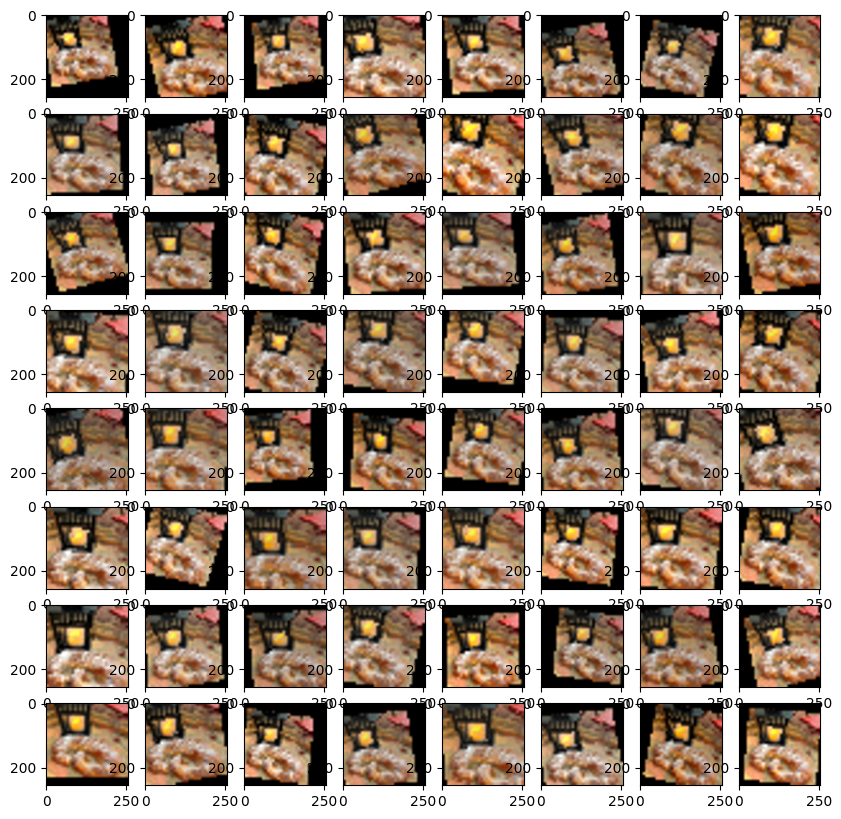

In [243]:
DIR_PATH = '/kaggle/input/dz-1-169/'

heigth_width = 32

# CLASSES = ['Крендель', 'Рогалик', 'Пончик']
CLASSES = ['Pretzel', 'Bagel', 'Donut']

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "%s/%s/*.*"%(DIR_PATH, CLASSES[CLASS])
  print(path_class_1)
  i=0
  for photo in glob(path_class_1):
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)
      if i > int(len(os.listdir("%s/%s/"%(DIR_PATH, CLASSES[CLASS])))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))

    
train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)


# Для подключения аугментации из лабы 3 надо перетащить класс Cifar100
# и подключить его в ячейке ниже "Создание Pytorch DataLoader'a"
# transform = T.Compose([
#    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
#    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=5),
# ])


print(len(train_X), len(test_X))

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8

for i in range(1, columns*rows +1):
    # Без аугментации
    img = Image.fromarray(train_X[i]).resize((256,256)) # без аугментации
    # С аугментацией
    # img = Image.fromarray((transform(torch.Tensor(train_X[i]).permute(2, 0, 1)/255.).\
    #             permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
    #             resize((256, 256))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Гиперпараметры и параметры

In [244]:
PRETRAINED=True
PRETRAINED_MODEL_NAME = "cifar100_mobilenetv2_x0_5" # - нечетные / cifar100_resnet20' - четные

# batch_size = 128 # по умолчанию
batch_size = 169

EPOCHS = 120

# keep_last = 2 # по умолчанию
# keep_last = len([*model.named_parameters()]) # равно без заморозки весов
keep_last = 10

LABEL_SMOOTHING=0.1

LR=0.1 # по умолчанию для RMSProp
MOMENTUM = 0 # по умолчанию для RMSProp
WEIGHT_DECAY = 0 # по умолчанию для RMSProp

# LR=0.01
# MOMENTUM = 0.9
# WEIGHT_DECAY = 5e-5


## Создание Pytorch DataLoader'a

Сюда надо добавить аугментацию!

In [246]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    
    # Для аугментации сюда подключить свой класс датасета
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2,
                                  persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader

dataloader

AttributeError: 'Compose' object has no attribute 'size'

## Загрузка предобученной модели Pytorch

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


model_hub = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       PRETRAINED_MODEL_NAME,
                       pretrained=PRETRAINED)
model_hub.to(device)

model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model_hub
).to(device)

# Вывод №1
# print(model(torch.rand(1, 32, 32, 3).to(device)))
# print(summary(model, input_size=(32, 32, 3)))
# print(model)

In [ ]:
print(PRETRAINED_MODEL_NAME)

# mobilenetv2
if PRETRAINED_MODEL_NAME == "cifar100_mobilenetv2_x0_5":
    in_features = model[1].classifier[1].in_features
    model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)

# Заморозка весов

In [ ]:
total = len([*model.named_parameters()])
params_to_update = []
print("Обучаемые параметры:")
for i, (name, param) in enumerate(model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False 
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
print('Всего у модели', total, 'параметров. Будем обучать', len(params_to_update), 'из них')

# Tensorboard

Tensorboard в ДЗ не просят.

Tensorboard Extension не работает в ноутбуках Kaggle

In [ ]:
# Общее имя для модели, логов в TensorBoard, архива с логами
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S")  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
MODEL_NAME

In [ ]:
train_log_dir = 'logs/tensorboard-dz1/train/' + MODEL_NAME
test_log_dir = 'logs/tensorboard-dz1/test/' + MODEL_NAME
train_summary_writer = tfsummary.create_file_writer(train_log_dir)
test_summary_writer = tfsummary.create_file_writer(test_log_dir)

# Обучение, Fine tunning

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
# используется SGD c momentum и L2-регуляризацией весов
# optimizer = optim.SGD(params_to_update, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.RMSprop(params_to_update, lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
REDRAW_EVERY = max(int(EPOCHS / 25), 1)
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])

pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
best_epoch_i = None
checkpoint_path = 'cifar_cnn_fine.pth' 

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        model, inputs, labels = model.to(device), inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
        
        # запись в tensorboard
        with train_summary_writer.as_default():
            tfsummary.scalar('loss', tmp[-1][0], step=pbar.n)
            tfsummary.scalar('accuracy', tmp[-1][1], step=pbar.n)
        
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # запись в tensorboard
    with test_summary_writer.as_default():
        tfsummary.scalar('loss', losses_val[-1][0][0], step=pbar.n)
        tfsummary.scalar('accuracy', losses_val[-1][0][1], step=pbar.n)
    
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        best_epoch_i = epoch
        torch.save(model.state_dict(), checkpoint_path)

    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    
    print(MODEL_NAME)
    print('Лучшая доля правильных ответов: %s на %s эпохе\n'
          'Текущая доля правильных ответов: %s (эпоха %s)' % (best_acc, best_epoch_i+1, acc, epoch+1))
    
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()

model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

# Просмотр TensorBoard не в Kaggle

Скачиваю архив с логами, чтобы посмотреть локально.

На панели справа ЛКМ по "обновить папку kaggle/working/" > листаем до файла .zip > три точки > Download.

In [ ]:
!zip -r "logs/tensorboard-logs-$MODEL_NAME.zip" logs/tensorboard-lab4 > /dev/null 2>&1

# Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
dataloader_test = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader_test[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader_test

In [ ]:
print(MODEL_NAME)

for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

# Сохранение модели и архитектуры

In [ ]:
!mkdir -p models/dz1

In [ ]:
torch.save(model, "models/dz1/" + MODEL_NAME + ".pt")

In [ ]:
!zip -r "models/dz1-$MODEL_NAME.zip" models/dz1 > /dev/null 2>&1

# Сохранение модели в ONNX

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "models/dz1/" + MODEL_NAME + ".onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,   # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],    # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})